# SIM Pattern Generator

### The Python version

From the [SI of the paper](http://www.pnas.org/content/suppl/2012/03/15/1119262109.DCSupplemental/pnas.201119262SI.pdf):



In [1]:
%pylab inline
#nice plotting
#import seaborn as sns
import numexpr as ne
#for minimizing the difference between the desired frequency and the calculated one
from scipy.optimize import minimize
#Need to be able to do polynomial fitting
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
#PIL allows us to write binary images, though we need a cludge, see 'Writing Binary Files.ipynb'
from PIL import Image
import os
import zipfile

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.ndimage import gaussian_filter

In [3]:
def pattern_gen(vecA, period, onfrac = 0.5, phase_idx = 0., phase_offset = 0., nphases =5, sizex =2048, sizey =1536, SIM_2D = True):
    '''
    Generates a binary SLM pattern for SIM
    
    This function follows [Fiolka et al.][1] definition
    
    Parameters
    ----------
    x : array_like
        the $\vec{a}$ from [1]. Defines the pattern orientation
    period : float
        Defines the period of the pattern
    onfrac : float
        The fraction of on pixels in the pattern
    phase_idx : int
        The phase of the pattern (see `nphases` for more info)
    phase_offset : float
        The offset in phase, mostly used for aligning patterns of different colors
    nphases : int
        the number of phases
    sizex : int
        size of the pattern
    sizey : int
        size of the pattern

    Returns
    -------
    pattern : ndarray
        A binary array representing a single bitplane to send to the SLM
    '''
    
    if not 0 < onfrac < 1:
        raise ValueError('onfrac must have a value between 0 and 1. onfrac = {}'.format(onfrac))
    
    vecN = np.array([[0,1],[-1,0]]).dot(vecA)
    vecB = vecN/norm(vecN)*period
    area = vecB.dot(vecN)
    onpix = area*onfrac
    phase_step = vecB/nphases
    
    if SIM_2D:
        #Then we only want to take steps of 2pi/n in illumination which means pi/n at the SLM
        phase_step/=2
    
    val = (phase_step*phase_idx+phase_offset/(2*pi)*vecB)
    
    #xx, yy = meshgrid(arange(sizex,dtype=float32),arange(sizey,dtype=float32))
    #my_grid = dstack((xx,yy))
    #my_grid -= val
    
    my_grid = indices((sizey,sizex),dtype=float)-val.reshape(2,1,1)
    
    #Need to reshape to matrix because of BLAS (http://stackoverflow.com/questions/11856293/numpy-dot-product-very-slow-using-ints)
    #mydot = my_grid.reshape(sizey*sizex,2).dot(vecN).reshape(sizey, sizex)
    mydot = (my_grid.reshape(2,sizey*sizex).T).dot(vecN).reshape(sizey, sizex)
    #mydot = my_grid.dot(vecN)
    return mod(mydot,area) < onpix

In [4]:
def pattern_gen(vecA, period, onfrac = 0.5, phase_idx = 0., phase_offset = 0., nphases =5, sizex =2048, sizey =1536, SIM_2D = True):
    '''
    Generates a binary SLM pattern for SIM
    
    This function follows [Fiolka et al.][1] definition
    
    Parameters
    ----------
    x : array_like
        the $\vec{a}$ from [1]. Defines the pattern orientation
    period : float
        Defines the period of the pattern
    onfrac : float
        The fraction of on pixels in the pattern
    phase_idx : int
        The phase of the pattern (see `nphases` for more info)
    phase_offset : float
        The offset in phase, mostly used for aligning patterns of different colors
    nphases : int
        the number of phases
    sizex : int
        size of the pattern
    sizey : int
        size of the pattern

    Returns
    -------
    pattern : ndarray
        A binary array representing a single bitplane to send to the SLM
    '''
    
    if not 0 < onfrac < 1:
        raise ValueError('onfrac must have a value between 0 and 1. onfrac = {}'.format(onfrac))
    
    vecN = np.array([[0,1],[-1,0]]).dot(vecA)
    vecB = vecN/norm(vecN)*period
    area = vecB.dot(vecN)
    onpix = area*onfrac
    phase_step = vecB/nphases
    
    if SIM_2D:
        #Then we only want to take steps of 2pi/n in illumination which means pi/n at the SLM
        phase_step/=2
    
    val = (phase_step*phase_idx+phase_offset/(2*pi)*vecB)
    
    xx, yy = meshgrid(arange(sizex,dtype=float32),arange(sizey,dtype=float32))
    my_grid = dstack((xx,yy))
    my_grid -= val
    
    #Need to reshape to matrix because of BLAS (http://stackoverflow.com/questions/11856293/numpy-dot-product-very-slow-using-ints)
    mydot = my_grid.reshape(sizey*sizex,2).dot(vecN).reshape(sizey, sizex)
    #mydot = my_grid.dot(vecN)
    return mod(mydot,area) < onpix

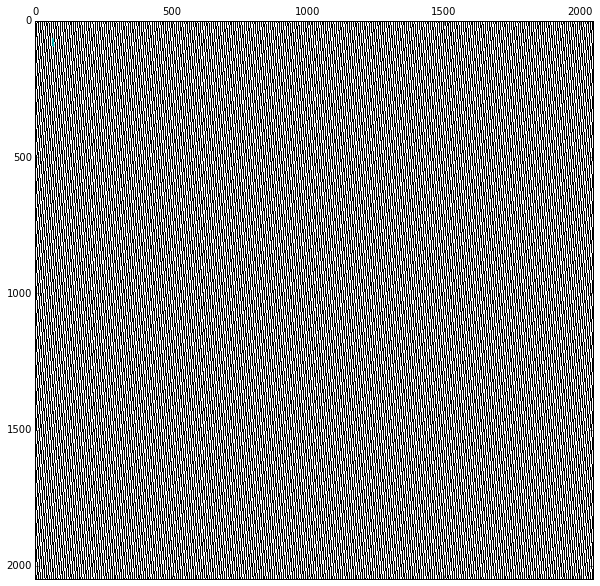

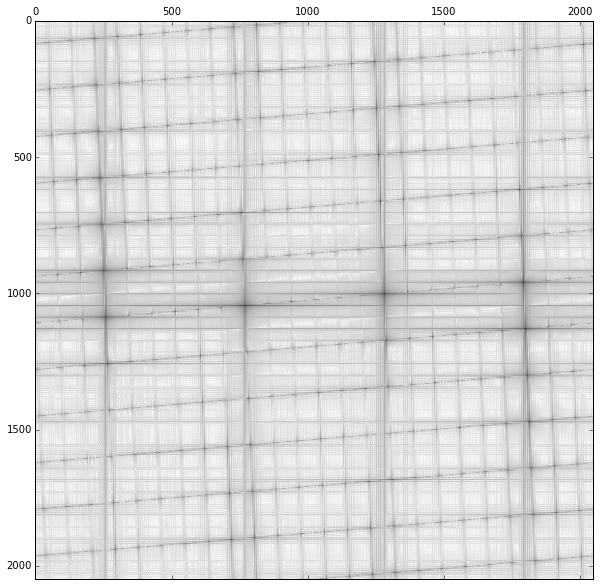

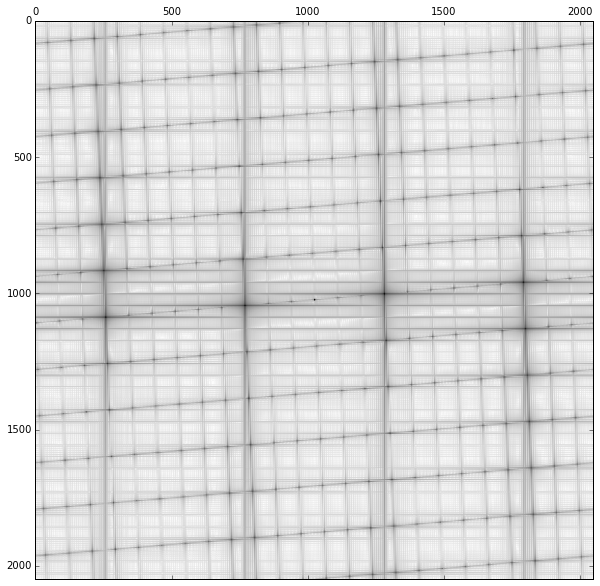

In [5]:
angle = [2,24]
pat =  pattern_gen(array(angle), 8, 0.5, 0, 0, 5,2048,2048)
pat_fft = ifftshift(fftn(fftshift(pat)))
figsize(10,10)
matshow(pat,cmap='Greys')
arrow(128/2,128/2,*angle,head_width=5, head_length=5,ec='c')
grid('off')
matshow(log(abs(pat_fft)+0.1),cmap='Greys')
grid('off')
matshow(log(gaussian_filter(abs(pat_fft),1)+0.1),cmap='Greys')
grid('off')

In [4]:
%%timeit
##comparison with mathematica
for i in range(3): 
    pat0 = pattern_gen([12, -1], 4.8277, 0.5, i, 0., 3, sizex = 1280, sizey = 1024) 

    name = 'pat-4.83256pixel-0.5DC-Ang0Ph{}_python.bmp'.format(i)
    #convert to binary and save
    pat_img = Image.fromarray((pat0*255).astype('uint8'),mode='L')
    pat_img.convert('1').save(os.path.join(name))

1 loops, best of 3: 470 ms per loop


In [6]:
def angles(phi, num_angles, amp):
    thetas = arange(0., num_angles)*pi/1./num_angles + phi
    return np.round(amp*array([cos(thetas), sin(thetas)])).T

In [7]:
@vectorize
def angle_diff(phi, num_angles, amp):
    my_angles = angles(phi,num_angles,amp)
    return mean(abs(pi/num_angles - abs(diff(arctan2(my_angles[:,0],my_angles[:,1])))))

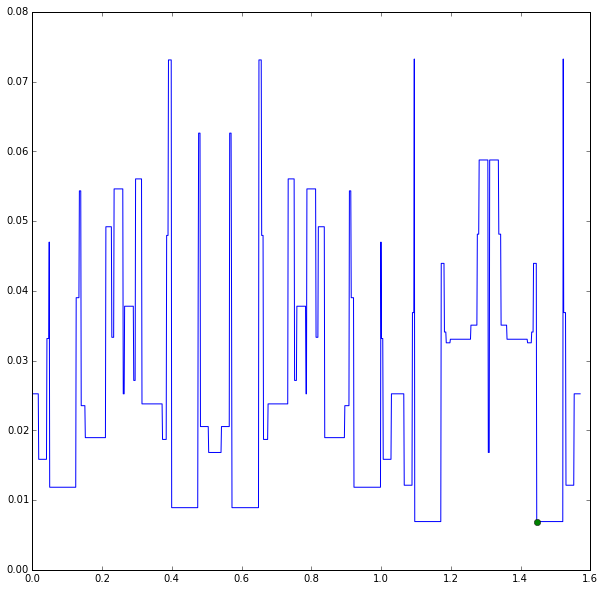

In [8]:
def print_best_angles(num_angles, amp):
    x = linspace(0,pi/2,100*amp)
    my_diffs = angle_diff(x,3,12)
    b = argmin(my_diffs)
    best_offset = x[b]
    plot(x,my_diffs)
    plot(best_offset, my_diffs[b],'o')
    
print_best_angles(3,12)

In [9]:
def best_angles(num_angles, amp):
    x = linspace(0,2*pi,100*amp)
    my_diffs = angle_diff(x,3,12)
    best_offset = x[argmin(my_diffs)]
    return angles(best_offset, num_angles, amp)

In [10]:
def ideal_period(wavelength, NA = 0.85):
    '''
    All units are in mm
    '''
    pixel_size = 8.2/1000 #pixel size in mm for QXGA display (4DD)
    fl = 250 #focal length of lens in mm
    fl2 = 300 #focal length of the second lens
    ftube = 200 #focal length of the tube lens, for Nikon this is 200 mm
    wl = wavelength/10**6 #wavelength of light
    mag = 1/100
    sigma = sqrt(2) * 12/pixel_size/4 #std dev of gaussian beam in units of pixels at the SLM
    pupil_diameter = 2*NA*mag*fl2    #Size of pupil image at first fourier plane
    hole_radius = 2*wl*fl/(2* pi * sigma *sqrt(2) * pixel_size) #this is the limit of hole size
    hole_radius = 0.1/2# this is more reasonable (50 um)
    period = wl * fl * (1/(pupil_diameter/2 - hole_radius))/ pixel_size #in mm
    
    return period

In [11]:
def pattern_period(vecA, period, onfrac = 0.5, phaseInd = 0., phaseOffset = 0., nphases = 5, sizex =2048, sizey =1536):
    '''
    Find the precise pattern period
    
    Using 2nd order polynomial fit along either axis
    '''
    
    #this is a standin for nextpow2, I don't know if there's a more efficient one, but its not going to
    #be a bottle neck
    n = 1<<(min(sizex,sizey)-1).bit_length()
    
    my_pat = pattern_gen(vecA, period, onfrac, phaseInd, phaseOffset, nphases, n, n)
    
    my_pat_fft = abs(ifftshift(fftn(fftshift(my_pat))))

    #I don't know why the first argument is negative?
    my_angle = arctan2(-vecA[0],vecA[1])
    
    peak = np.round(n/(period/array([sin(my_angle), cos(my_angle)])))
    
    #pull the 3x3 region around the peak
    region_size = 3
    start = -(region_size-1)/2
    end = region_size+start

    my_pat_fft_subx = my_pat_fft[n/2+peak[0]+start:n/2+peak[0]+end,n/2+peak[1]]
    my_pat_fft_suby = my_pat_fft[n/2+peak[0],n/2+peak[1]+start:n/2+peak[1]+end]

    x = arange(start,end)
    
    xfit = polyfit(x, my_pat_fft_subx,2)
    yfit = polyfit(x, my_pat_fft_suby,2)

    x0 = -xfit[1]/(2*xfit[0])
    y0 = -yfit[1]/(2*yfit[0])

    #precisepeak = peak+poly2dmax(insert(clf.coef_,(3),0))
    precisepeak = peak+[x0,y0]
    #print(precisepeak)
    
    preciseangle = arctan2(precisepeak[0],precisepeak[1])
    
    #precise_period = n/norm(precisepeak)
    precise_period = n/precisepeak[0]*sin(preciseangle)
    
    #print('{:.20f}'.format(precise_period))
    
    return precise_period

In [9]:
#testing different solvers, note that Nelder-Mead and Powell methods are the
#only ones that seem to work for this function.
def objf_l1(period, iperiod, size = 1024):
    angle = array([1,12])
    data = array([pattern_period(angle, period,phaseInd = n,sizex = size) for n in range(1)])
    return mean(abs(data-iperiod))

def objf_l2(*args):
    return objf_l1(*args)**2

%timeit minimize(objf_l1, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
%timeit minimize(objf_l1, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

%timeit minimize(objf_l2, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
%timeit minimize(objf_l2, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

res_l1_nm = minimize(objf_l1, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
res_l1_p = minimize(objf_l1, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

res_l2_nm = minimize(objf_l2, 8.4,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
res_l2_p = minimize(objf_l2, 8.4,method='Powell',args=(ideal_period(568, 0.7),512))

1 loops, best of 3: 1.64 s per loop
1 loops, best of 3: 2.71 s per loop
1 loops, best of 3: 1.39 s per loop
1 loops, best of 3: 3.66 s per loop


In [10]:
print('x values')
print('L1-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l1_nm['x'][0],res_l1_p['x']))
print('L2-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l2_nm['x'][0],res_l2_p['x']))
print('Func Calls')
print('L1-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l1_nm['nfev'],res_l1_p['nfev']))
print('L2-norm: Nelder-Mead = {}\tPowell = {}'.format(res_l2_nm['nfev'],res_l2_p['nfev']))
print('Differences')
print('L1-norm: Nelder-Mead - Powell = {}'.format(res_l1_nm['fun']-res_l1_p['fun']))
print('L1-norm: Nelder-Mead - Powell = {}'.format(res_l1_nm['fun']**2-res_l1_p['fun']**2))
print('L2-norm: Nelder-Mead - Powell = {}'.format(res_l2_nm['fun']-res_l2_p['fun']))

x values
L1-norm: Nelder-Mead = 8.436145019531251	Powell = 8.436047020234469
L2-norm: Nelder-Mead = 8.436145019531251	Powell = 8.436255263697804
Func Calls
L1-norm: Nelder-Mead = 33	Powell = 55
L2-norm: Nelder-Mead = 28	Powell = 73
Differences
L1-norm: Nelder-Mead - Powell = -0.0003552140126465986
L1-norm: Nelder-Mead - Powell = -1.4063966543938126e-07
L2-norm: Nelder-Mead - Powell = -3.68334662853476e-07


It looks like the simplex (`'Nelder-Mead'`) algorithm is the best for this problem. Barring more complex convex methods.

In [24]:
iperiod = ideal_period(568,0.7)

def objf(period, iperiod, size = 1024):
    return objf_l1(period, iperiod, size)/iperiod*100

x = linspace(iperiod-0.05,iperiod+0.05,101)
y512 = array([objf(period, iperiod,512) for period in x])
y1024 = array([objf(period, iperiod,1024) for period in x])
y2048 = array([objf(period, iperiod,2048) for period in x])

In [22]:
res_512 = minimize(objf, iperiod ,method='Nelder-Mead',args=(ideal_period(568, 0.7),512))
res_1024 = minimize(objf, iperiod ,method='Nelder-Mead',args=(ideal_period(568, 0.7),1024))
res_2048 = minimize(objf, iperiod ,method='Nelder-Mead',args=(ideal_period(568, 0.7),2048))

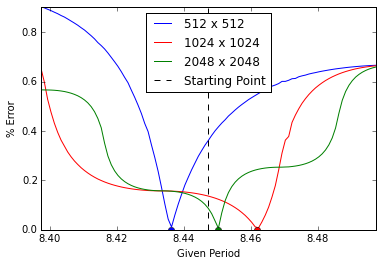

In [25]:
plot(x,y512,'b',label='512 x 512')
plot(res_512['x'],res_512['fun'],'bo')#,label='512 Optimized point')
plot(x,y1024,'r',label='1024 x 1024')
plot(res_1024['x'],res_1024['fun'],'ro')#,label='1024 Optimized point')
plot(x,y2048,'g',label='2048 x 2048')
plot(res_2048['x'],res_2048['fun'],'go')#,label='1024 Optimized point')
axis('tight')
axvline(iperiod,color='k',linestyle='dashed',label='Starting Point')
xlabel('Given Period')
ylabel('% Error')
legend(loc='best')
savefig("PeriodOpt.pdf")

In [12]:
def opt_period(iperiod,angle,**kwargs):
    def objf_l1(period):
        data = array([pattern_period(angle, period, **kwargs) for n in range(1)])
        return mean(abs(data-iperiod))
    
    return minimize(objf_l1, iperiod ,method='Nelder-Mead')['x']

In [16]:
%timeit opt_period(ideal_period(568, 0.85),array([1,12]))

1 loops, best of 3: 28.2 s per loop


In [17]:
my_per = opt_period(ideal_period(568, 0.7),array([1,12]))

In [18]:
pat = pattern_gen([1,12], my_per)

#this is cludgy but seems necessary.
pat_img = Image.fromarray((pat*255).astype('uint8'),mode='L')

#write the image
pat_img.convert('1').save('TestPat.bmp')

In [65]:
seq_dir = os.path.join('HHMI_R11_Seq')
seq_files = ['SEQUENCES']
i = 0
for file in os.listdir(seq_dir):
    if '.seq11' in file:
        seq_files.append(chr(65+i)+' "'+file+'"')
        i += 1
        
seq_files.append('SEQUENCES_END')
print("\n".join(seq_files))

SEQUENCES
A "48070 HHMI 10ms.seq11"
B "48071 HHMI 50ms.seq11"
C "48075 HHMI 5ms.seq11"
D "48076 HHMI 20ms.seq11"
E "48077 HHMI 24 50ms.seq11"
F "48078 HHMI 24 1ms.seq11"
G "48083 HHMI 1ms 1-bit Lit Balanced.seq11"
H "48084 HHMI 2ms 1-bit Lit Balanced.seq11"
SEQUENCES_END


In [9]:
with zipfile.ZipFile('Rep568.repz11','r') as my_rep:
    print(my_rep.namelist())
    with my_rep.open('Rep568.rep') as rep:
        print(rep.read().decode())

['Rep568.rep', '48070 HHMI 10ms.seq11', '48071 HHMI 50ms.seq11', '48075 HHMI 5ms.seq11', '48076 HHMI 20ms.seq11', '48077 HHMI 24 50ms.seq11', '48078 HHMI 24 1ms.seq11', '48083 HHMI 1ms 1-bit Lit Balanced.seq11', '48084 HHMI 2ms 1-bit Lit Balanced.seq11', 'pat-6.92003pixel-0.5DC-Ang0Ph0.bmp', 'pat-6.92003pixel-0.5DC-Ang0Ph1.bmp', 'pat-6.92003pixel-0.5DC-Ang0Ph2.bmp', 'pat-6.92003pixel-0.5DC-Ang0Ph3.bmp', 'pat-6.92003pixel-0.5DC-Ang0Ph4.bmp', 'pat-6.92929pixel-0.5DC-Ang1Ph0.bmp', 'pat-6.92929pixel-0.5DC-Ang1Ph1.bmp', 'pat-6.92929pixel-0.5DC-Ang1Ph2.bmp', 'pat-6.92929pixel-0.5DC-Ang1Ph3.bmp', 'pat-6.92929pixel-0.5DC-Ang1Ph4.bmp', 'pat-6.93262pixel-0.5DC-Ang2Ph0.bmp', 'pat-6.93262pixel-0.5DC-Ang2Ph1.bmp', 'pat-6.93262pixel-0.5DC-Ang2Ph2.bmp', 'pat-6.93262pixel-0.5DC-Ang2Ph3.bmp', 'pat-6.93262pixel-0.5DC-Ang2Ph4.bmp', 'pat-7.36825pixel-0.5DC-Ang0Ph0.bmp', 'pat-7.36825pixel-0.5DC-Ang0Ph1.bmp', 'pat-7.36825pixel-0.5DC-Ang0Ph2.bmp', 'pat-7.36825pixel-0.5DC-Ang0Ph3.bmp', 'pat-7.36825pixel-0.5DC

In [13]:
'''
We can use sets as a way to keep track of images and sequences.

Images and sequences will be denoted by strings referring to the actual file name

A repetoire will only contain a list of RunningOrders and have a method to write out running orders.

It should also have the ability to read in a .rep file

Need a method to return a given running order, by name
'''

class RunningOrder(object):
    '''
    A class representing a running order for a 4DD SLM
    '''
    
    def __init__(self, name, triggered = True):
        self._name = name
        #we want these properties to be immutable and we don't want duplicates
        self._sequences = set()
        self._bitplanes = set()
        self.triggered = triggered
        self._RO = []
        
    @property
    def name(self):
        return self._name
    
    @property
    def sequences(self):
        return self._sequences
    
    @property
    def bitplanes(self):
        return self._bitplanes
    
    @property
    def RO(self):
        return self._RO
    
    def addbitplane(self, sequence, bitplane, position = None):
        '''
        A function to add sequence bitplane pairs to a running order
        '''
        self._sequences.add(sequence)
        self._bitplanes.add(bitplane)
            
        seq_bp = {'sequence' : sequence, 'bitplane' : bitplane}
        
        if position is None:
            self._RO.append(seq_bp)
        else:
            self._RO.insert(position, seq_bp)

class Repetoire(object):
    '''
    This object holds a list of Running orders. It has the ability to output .rep files
    
    Further functionality will be to read in .rep files.
    '''
    
    def __init__(self, listofROs = None):
        self._ROs = []
        self._sequences = set()
        self._bitplanes = set()
        if listofROs is not None:
            for RO in listofROs:
                self.add_RO(RO)
        
    def add_RO(self, RO):
        
        if isinstance(RO, list):
            self.add_RO(RO.pop())
        
        if not isinstance(RO, RunningOrder):
            raise TypeError('Not a RunningOrder')
        else:
            self._ROs.append(RO)
            self._sequences |= RO.sequences
            self._bitplanes |= RO.bitplanes

    def __str__(self):
        '''
        This function writes the repetoire
        '''
        
        toreturn = ''
        
        #If ROs is empty
        if not len(self._ROs):
            return toreturn
        
        ####################
        # MAKING SEQUENCES #
        ####################
        
        #need to save the letter assignments
        seq_dict = {}
        
        seqs = ['SEQUENCES']
        for i, seq in enumerate(sorted(self._sequences)):
            char = chr(65+i)
            seqs.append(char+' "'+seq+'"')
            seq_dict[seq] = char
        
        seqs.append('SEQUENCES_END\n\n')
        
        toreturn = "\n".join(seqs)
        
        ####################
        # MAKING BITPLANES #
        ####################
        
        bp_dict = {}
        bps = ['IMAGES']
        for i, bp in enumerate(sorted(self._bitplanes)):
            bps.append('1 "'+bp+'"')
            bp_dict[bp] = i
        
        bps.append('IMAGES_END\n\n')
        
        toreturn += "\n".join(bps)
        
        #Need to have at least one RunningOrder be Default, why not the first one?
        #If no DEFAULT then MetroCon will continue to look for one and fail.
        toreturn += 'DEFAULT '
        #sort the RunningOrders by name
        for RO in self._ROs:#.sort(key=lambda x: x.name):
            toreturn += self._writeRO(RO, seq_dict, bp_dict)
            
        return toreturn
        
    @staticmethod
    def _writeRO(RO, seq_dict, bp_dict):
        '''
        This function will write the repetoire based on the sequence dict and image dict
        
        It assumes that all that is wanted is standard SIM sequences
        '''
        
        toreturn = ['"{}"'.format(RO.name)]
        
        toreturn.append('[HWA\n')
        
        if not RO.triggered:
            toappend = ' {'
        
        for seq_bp in RO.RO:
            seq = seq_bp['sequence']
            bp = seq_bp['bitplane']
            if RO.triggered:
                toreturn.append(' <t({0},{1}) >\n {{f ({0},{1}) }}'.format(seq_dict[seq],bp_dict[bp]))
            else:
                toappend += '({0},{1}) '.format(seq_dict[seq],bp_dict[bp])
        
        if not RO.triggered:
            toappend += '}'
            toreturn.append(toappend)
            
        toreturn.append(']\n\n')
        
        return '\n'.join(toreturn)
        

In [64]:
my_seqs = ['test_seq{}.seq11'.format(i) for i in range(5)]
my_bps = ['test_bp{}.bmp'.format(i) for i in range(5)]

ROlist = []

for seq in my_seqs:
    my_RO = RunningOrder('My Running Order for {}'.format(seq),triggered=False)
    for bp in my_bps:
        my_RO.addbitplane(seq,bp)
    ROlist.append(my_RO)
    
my_Rep = Repetoire(ROlist)

In [65]:
print(my_Rep)

SEQUENCES
A "test_seq0.seq11"
B "test_seq1.seq11"
C "test_seq2.seq11"
D "test_seq3.seq11"
E "test_seq4.seq11"
SEQUENCES_END

IMAGES
1 "test_bp0.bmp"
1 "test_bp1.bmp"
1 "test_bp2.bmp"
1 "test_bp3.bmp"
1 "test_bp4.bmp"
IMAGES_END

DEFAULT "My Running Order for test_seq0.seq11"
[HWA

 {(A,0) (A,1) (A,2) (A,3) (A,4) }
]

"My Running Order for test_seq1.seq11"
[HWA

 {(B,0) (B,1) (B,2) (B,3) (B,4) }
]

"My Running Order for test_seq2.seq11"
[HWA

 {(C,0) (C,1) (C,2) (C,3) (C,4) }
]

"My Running Order for test_seq3.seq11"
[HWA

 {(D,0) (D,1) (D,2) (D,3) (D,4) }
]

"My Running Order for test_seq4.seq11"
[HWA

 {(E,0) (E,1) (E,2) (E,3) (E,4) }
]




In [104]:
with open('test.txt','w') as test:
    test.write(str(my_Rep))

In [30]:
for x in linspace(0.78,0.85,8):
    print(x)

0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85


In [17]:
from matplotlib.patches import Circle, Wedge, Polygon

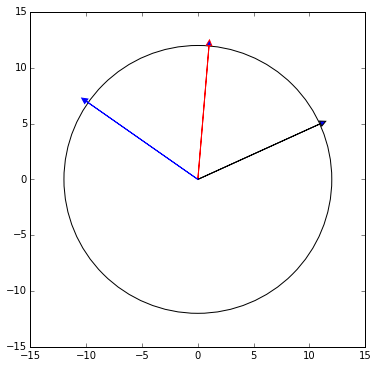

In [18]:
fig,ax = subplots(1,1,squeeze=True, figsize=(6,6))
circle = Circle((0,0),12,fill=False)
ax.add_patch(circle)
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
colors = ('r','k','b')
for ang, c in zip([[1,12],[11, 5], [-10,7]],colors):
    ax.arrow(0,0,ang[0],ang[1],head_width=0.5, head_length=0.5,ec=c)

In [15]:
best_angles(3,12)

array([[  1.,  12.],
       [-10.,   7.],
       [-11.,  -5.]])

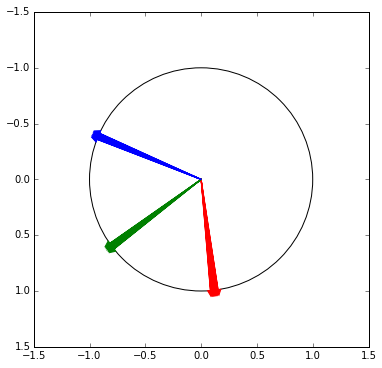

In [29]:
fig,ax = subplots(1,1,squeeze=True, figsize=(6,6))
circle = Circle((0,0),1,fill=False)
ax.add_patch(circle)
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
colors = ('r','g','b')
ax.invert_yaxis()
for i in range(10,21):
    for ang, c in zip(best_angles(3,i),colors):
        ang /= norm(ang)
        ax.arrow(0,0,ang[0],ang[1],head_width=0.05, head_length=0.05,ec=c,fc=c)
        figsize(5,5)
        #pat =  pattern_gen(array(ang), 8, 0.5, 0, 0, 5,128,128)
        #matshow(pat,cmap='Greys')
        #arrow(128/2,128/2,*ang,head_width=5, head_length=5,ec=c,fc=c)

In [19]:
##Regular SIM for 488 and 561
onfrac = 0.5
my_angles = best_angles(3,12)
    
num_phases = 3

name = 'SIM 2D 488 and 561'

#open zip file, make sure the compression is set to ZIP_DEFLATED (8)
with zipfile.ZipFile('{}.repz11'.format(name), 'w', compression=zipfile.ZIP_DEFLATED) as myzip:

    opt = True

    my_dir = os.path.join(name,'')
    if not os.path.isdir(my_dir):
        print('Making '+my_dir)
        os.mkdir(my_dir)

    NAs = linspace(0.78,0.85,8)
    
    ROlist = []
    
    seq = '48070 HHMI 10ms.seq11'
    
    myzip.write(os.path.join('HHMI_R11_Seq',seq),arcname=seq)
    
    for wl in [488, 561]:
        for NA in NAs:
            print('{} NA {}'.format(wl, NA))

            iperiod = ideal_period(wl,NA=NA)
            super_RO = RunningOrder('{} SIM NA {}'.format(wl,NA))

            RO_all_t = RunningOrder('{} NA {} All Orientations Triggered'.format(wl,NA))
            RO_all = RunningOrder('{} NA {} All Orientations'.format(wl,NA),triggered=False)

            patall =zeros((1536, 2048)).astype(bool)

            for angle in my_angles:

                #calculate degree from angle for filename
                degree = arctan2(angle[0],angle[1])*180/pi

                RO1orient = RunningOrder('{} NA {} {:+.2f} degrees'.format(wl, NA, degree), triggered=False)

                #optimize the angle
                if opt:
                    print('Optimizing angle = {:+.2f} degrees'.format(degree))
                    my_per = opt_period(iperiod,angle)
                else:
                    my_per = iperiod

                for phase in range(num_phases):
                    #generate pattern
                    pat = pattern_gen(angle, my_per,onfrac=onfrac,phase_idx=phase,nphases=num_phases)

                    #make image object
                    pat_img = Image.fromarray((pat*255).astype('uint8'),mode='L')

                    #generate filename, put orientation in front, so that its consistent
                    name = 'pat-{:.2f}NA{:+.1f}deg-{:02d}ph-{:.4f}pix-{:.2f}DC.bmp'.format(NA, degree,phase,my_per[0],onfrac)

                    #convert to binary and save
                    pat_img.convert('1').save(os.path.join(my_dir,name))

                    #move to zip file and save
                    myzip.write(os.path.join(my_dir,name),arcname=name)

                    super_RO.addbitplane(seq,name)

                    if not phase:
                        RO1orient.addbitplane(seq,name)
                        #add to all angles pattern
                        patall |= pat

                    print('Wrote file: {}'.format(name))

                ROlist.append(RO1orient)

            #make image object for all
            patall_img = Image.fromarray((patall*255).astype('uint8'),mode='L')

            #generate filename, put orientation in front, so that its consistent
            nameall = 'pat-{:.2f}NA-{:.4f}pix-{:.2f}DC_allangles.bmp'.format(NA,my_per[0],onfrac)

            #convert to binary and save
            patall_img.convert('1').save(os.path.join(my_dir,nameall))

            #move to zip file and save
            myzip.write(os.path.join(my_dir,nameall),arcname=nameall)

            RO_all_t.addbitplane(seq,nameall)
            RO_all.addbitplane(seq,nameall)

            ROlist.append(super_RO)
            ROlist.append(RO_all_t)
            ROlist.append(RO_all)

    my_Rep = Repetoire(ROlist)

    #write the rep file
    with open(os.path.join(my_dir,'{}.rep'.format(name)),'w') as repfile:
        repfile.write(str(my_Rep))

    #now add the file to the zip
    myzip.write(os.path.join(my_dir,'{}.rep'.format(name)),arcname='{}.rep'.format(name))
    
print(my_Rep)

Making SIM 2D 488 and 561\
488 NA 0.78
Optimizing angle = +4.76 degrees
Wrote file: pat-0.78NA+4.8deg-00ph-6.4920pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-01ph-6.4920pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-02ph-6.4920pix-0.50DC.bmp
Optimizing angle = -55.01 degrees
Wrote file: pat-0.78NA-55.0deg-00ph-6.4949pix-0.50DC.bmp
Wrote file: pat-0.78NA-55.0deg-01ph-6.4949pix-0.50DC.bmp
Wrote file: pat-0.78NA-55.0deg-02ph-6.4949pix-0.50DC.bmp
Optimizing angle = -114.44 degrees
Wrote file: pat-0.78NA-114.4deg-00ph-6.4953pix-0.50DC.bmp
Wrote file: pat-0.78NA-114.4deg-01ph-6.4953pix-0.50DC.bmp
Wrote file: pat-0.78NA-114.4deg-02ph-6.4953pix-0.50DC.bmp
488 NA 0.79
Optimizing angle = +4.76 degrees
Wrote file: pat-0.79NA+4.8deg-00ph-6.4094pix-0.50DC.bmp
Wrote file: pat-0.79NA+4.8deg-01ph-6.4094pix-0.50DC.bmp
Wrote file: pat-0.79NA+4.8deg-02ph-6.4094pix-0.50DC.bmp
Optimizing angle = -55.01 degrees
Wrote file: pat-0.79NA-55.0deg-00ph-6.4147pix-0.50DC.bmp
Wrote file: pat-0.79NA-55.0deg-01ph-6.4147

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [10]:
#Super SIM
onfrac = 0.5
num_angles = 3
my_angles = best_angles(num_angles,12)
    
num_phases = 24

wl = 561

#open zip file, make sure the compression is set to ZIP_DEFLATED (8)
with zipfile.ZipFile('SIM{}_2D.repz11'.format(wl), 'w', compression=zipfile.ZIP_DEFLATED) as myzip:

    opt = True

    my_dir = os.path.join('{} SIM 2D'.format(wl),'')
    if not os.path.isdir(my_dir):
        print('Making '+my_dir)
        os.mkdir(my_dir)

    NAs = linspace(0.78,0.85,8)
    
    ROlist = []
    
    seq = '48070 HHMI 10ms.seq11'
    
    myzip.write(os.path.join('HHMI_R11_Seq',seq),arcname=seq)
    
    for NA in NAs:
        print('NA {}'.format(NA))
        
        iperiod = ideal_period(wl,NA=NA)
        super_RO = RunningOrder('Super SIM NA {}'.format(NA))
        reg_RO = RunningOrder('SIM NA {}'.format(NA))
        
        RO_all_t = RunningOrder('NA {} All Orientations Triggered'.format(NA))
        RO_all = RunningOrder('NA {} All Orientations'.format(NA),triggered=False)
        
        patall =zeros((1536, 2048))
        
        for angle in my_angles:
            
            #calculate degree from angle for filename
            degree = rad2deg(arctan2(angle[0],angle[1]))
            
            RO1orient = RunningOrder('NA {} {:+.2f} degrees'.format(NA, degree), triggered=False)
            
            #optimize the angle
            if opt:
                print('Optimizing angle = {:+.2f} degrees'.format(degree))
                my_per = opt_period(iperiod,angle)
            else:
                my_per = iperiod

            for phase in range(num_phases):
                #generate pattern, but with two periods
                pat = pattern_gen(angle, my_per,onfrac=onfrac,phase_idx=phase,nphases=num_phases,SIM_2D=False)
                
                #make image object
                pat_img = Image.fromarray((pat*255).astype('uint8'),mode='L')
                
                #generate filename, put orientation in front, so that its consistent
                name = 'pat-{:.2f}NA{:+.1f}deg-{:02d}ph-{:.4f}pix-{:.2f}DC.bmp'.format(NA, degree,phase,my_per[0],onfrac)
                
                #convert to binary and save
                pat_img.convert('1').save(os.path.join(my_dir,name))
                
                #move to zip file and save
                myzip.write(os.path.join(my_dir,name),arcname=name)
                
                super_RO.addbitplane(seq,name)
                
                if not phase:
                    RO1orient.addbitplane(seq,name)
                    #add to all angles pattern
                    patall += pat
                
                #only pull the first three phases so that we can do regular SIM too
                if (phase % (num_phases//6) == 0) and (phase/num_phases*2 < 1):
                    reg_RO.addbitplane(seq,name)
                
                print('Wrote file: {}'.format(name))
                
            ROlist.append(RO1orient)
            
        #make image object for all
        patall_img = Image.fromarray((patall/num_angles*255).astype('uint8'),mode='L')

        #generate filename, put orientation in front, so that its consistent
        nameall = 'pat-{:.2f}NA-{:.4f}pix-{:.2f}DC_allangles.bmp'.format(NA,my_per[0],onfrac)

        #convert to binary and save
        patall_img.convert('1').save(os.path.join(my_dir,nameall))

        #move to zip file and save
        myzip.write(os.path.join(my_dir,nameall),arcname=nameall)
        
        RO_all_t.addbitplane(seq,nameall)
        RO_all.addbitplane(seq,nameall)
        
        ROlist.append(super_RO)
        ROlist.append(reg_RO)
        ROlist.append(RO_all_t)
        ROlist.append(RO_all)
                
    my_Rep = Repetoire(ROlist)
    
    #write the rep file
    with open(os.path.join(my_dir,'SIM{}_2D.rep'.format(wl)),'w') as repfile:
        repfile.write(str(my_Rep))
        
    #now add the file to the zip
    myzip.write(os.path.join(my_dir,'SIM{}_2D.rep'.format(wl)),arcname='SIM{}_2D.rep'.format(wl))
    
print(my_Rep)

Making 561 SIM 2D\
NA 0.78
Optimizing angle = +4.76 degrees
Wrote file: pat-0.78NA+4.8deg-00ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-01ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-02ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-03ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-04ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-05ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-06ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-07ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-08ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-09ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-10ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-11ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-12ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-13ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-14ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-15ph-7.4641pix-0.50DC.bmp
Wrote file: pat-0.78NA+4.8deg-16ph-7.4641pix

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [31]:
for i in range(10,21):
    for ang in best_angles(3,i):
        print(rad2deg(arctan2(ang[0],ang[1])))

5.7105931375
-53.1301023542
-113.962488975
5.19442890773
-52.1250163489
-111.801409486
4.76364169073
-55.0079798014
-114.44395478
8.74616226256
-51.3401917459
-112.619864948
8.13010235416
-53.9726266149
-111.037511025
7.59464336859
-53.1301023542
-113.198590514
7.1250163489
-52.4314079712
-111.801409486
6.70983680776
-54.462322208
-113.629377731
6.34019174591
-51.8427734126
-112.380135052
6.00900595749
-53.7461622626
-111.250505507
5.7105931375
-53.1301023542
-113.962488975


In [39]:
avg_dev = []
for i in range(10,21):
    degs = array([rad2deg(arctan2(ang[0],ang[1])) for ang in best_angles(3,i)])
    avg_dev.append((diff(degs)+60).mean())

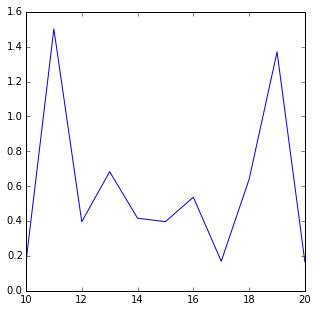

In [42]:
plot(arange(10,21),abs(array(avg_dev)))

In [43]:
arange(10,21)[abs(array(avg_dev)).argmin()]

10

In [44]:
abs(array(avg_dev)).argmin()

0

In [46]:
abs(array(avg_dev))

array([ 0.16345894,  1.5020808 ,  0.39620176,  0.68301361,  0.41619331,
        0.39661694,  0.53678708,  0.16960727,  0.6398366 ,  1.37024427,
        0.16345894])

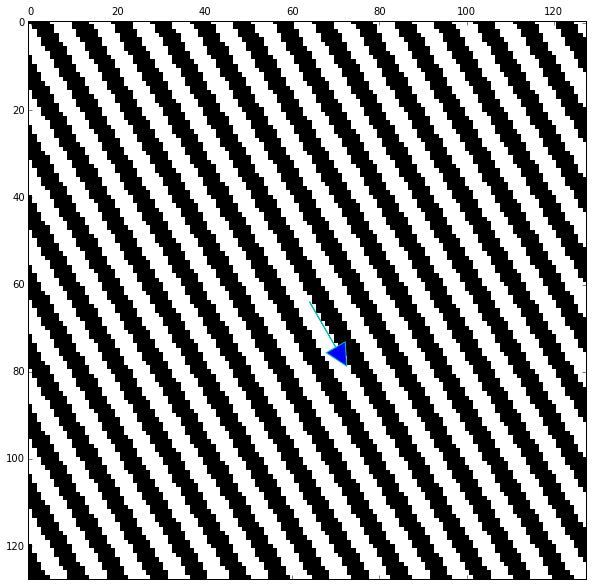

In [53]:
theta=deg2rad(60)
angle = [12*cos(theta),12*sin(theta)]
pat =  pattern_gen(array(angle), 8, 0.5, 0, 0, 5,128,128)
pat_fft = ifftshift(fftn(fftshift(pat)))
figsize(10,10)
matshow(pat,cmap='Greys')
arrow(128/2,128/2,*angle,head_width=5, head_length=5,ec='c')
grid('off')

In [63]:
#Super SIM
onfrac = 0.5
num_angles = 3
num_phases = 24

wl = 561

#open zip file, make sure the compression is set to ZIP_DEFLATED (8)
with zipfile.ZipFile('SIM{}_2D_test.repz11'.format(wl), 'w', compression=zipfile.ZIP_DEFLATED) as myzip:

    opt = False

    my_dir = os.path.join('SIM{}_2D_test'.format(wl),'')
    if not os.path.isdir(my_dir):
        print('Making '+my_dir)
        os.mkdir(my_dir)

    NA = 0.82
    
    ROlist = []
    
    seq = '48070 HHMI 10ms.seq11'
    
    myzip.write(os.path.join('HHMI_R11_Seq',seq),arcname=seq)
    
    for length in range(10,21):
        print('Length {}'.format(length))
        my_angles = best_angles(num_angles,length)
        
        iperiod = ideal_period(wl,NA=NA)
        super_RO = RunningOrder('SIM NA {}'.format(NA))
        
        RO_all_t = RunningOrder('Length {} All Orientations Triggered'.format(length))
        RO_all = RunningOrder('Length {} All Orientations'.format(length),triggered=False)
        
        patall =zeros((1536, 2048))
        
        for angle in my_angles:
            
            #calculate degree from angle for filename
            degree = rad2deg(arctan2(angle[0],angle[1]))
            
            RO1orient = RunningOrder('NA {} {:+.2f} degrees'.format(NA, degree), triggered=False)
            
            #optimize the angle
            if opt:
                print('Optimizing angle = {:+.2f} degrees'.format(degree))
                my_per = opt_period(iperiod,angle)[0]
            else:
                my_per = iperiod

            for phase in range(num_phases):
                #generate pattern, but with two periods
                pat = pattern_gen(angle, my_per,onfrac=onfrac,phase_idx=phase,nphases=num_phases,SIM_2D=False)
                
                #make image object
                pat_img = Image.fromarray((pat*255).astype('uint8'),mode='L')
                
                #generate filename, put orientation in front, so that its consistent
                name = 'pat-{:.2f}NA{:+.1f}deg-{:02d}ph-{:.4f}pix-{:.2f}DC.bmp'.format(NA, degree,phase,my_per,onfrac)
                
                #convert to binary and save
                pat_img.convert('1').save(os.path.join(my_dir,name))
                
                #move to zip file and save
                myzip.write(os.path.join(my_dir,name),arcname=name)
                
                super_RO.addbitplane(seq,name)
                
                if not phase:
                    RO1orient.addbitplane(seq,name)
                    #add to all angles pattern
                    patall += pat
                
                
                print('Wrote file: {}'.format(name))
                
            ROlist.append(RO1orient)
            
        #make image object for all
        patall_img = Image.fromarray((patall/num_angles*255).astype('uint8'),mode='L')

        #generate filename, put orientation in front, so that its consistent
        nameall = 'pat-{:.2f}NA-{:.4f}pix-{:.2f}DC-{}len_allangles.bmp'.format(NA,my_per,onfrac,length)

        #convert to binary and save
        patall_img.convert('1').save(os.path.join(my_dir,nameall))

        #move to zip file and save
        myzip.write(os.path.join(my_dir,nameall),arcname=nameall)
        
        RO_all_t.addbitplane(seq,nameall)
        RO_all.addbitplane(seq,nameall)
        
        ROlist.append(super_RO)
        ROlist.append(RO_all_t)
        ROlist.append(RO_all)
                
    my_Rep = Repetoire(ROlist)
    
    #write the rep file
    with open(os.path.join(my_dir,'SIM{}_2D.rep'.format(wl)),'w') as repfile:
        repfile.write(str(my_Rep))
        
    #now add the file to the zip
    myzip.write(os.path.join(my_dir,'SIM{}_2D.rep'.format(wl)),arcname='SIM{}_2D.rep'.format(wl))
    
print(my_Rep)

Length 10
Wrote file: pat-0.82NA+5.7deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA+5.7deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA+5.7deg-02ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-53.1deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-53.1deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-53.1deg-02ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-114.0deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-114.0deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-114.0deg-02ph-7.0970pix-0.50DC.bmp
Length 11
Wrote file: pat-0.82NA+5.2deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA+5.2deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA+5.2deg-02ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-52.1deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-52.1deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-52.1deg-02ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-111.8deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-111.8deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: 

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: UserWarning: Duplicate name: 'pat-0.82NA-53.1deg-00ph-7.0970pix-0.50DC.bmp'
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: UserWarning: Duplicate name: 'pat-0.82NA-53.1deg-01ph-7.0970pix-0.50DC.bmp'



Wrote file: pat-0.82NA-53.1deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-53.1deg-02ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-113.2deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-113.2deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-113.2deg-02ph-7.0970pix-0.50DC.bmp
Length 16
Wrote file: pat-0.82NA+7.1deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA+7.1deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA+7.1deg-02ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-52.4deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-52.4deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-52.4deg-02ph-7.0970pix-0.50DC.bmp

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: UserWarning: Duplicate name: 'pat-0.82NA-53.1deg-02ph-7.0970pix-0.50DC.bmp'
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: UserWarning: Duplicate name: 'pat-0.82NA-111.8deg-00ph-7.0970pix-0.50DC.bmp'



Wrote file: pat-0.82NA-111.8deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-111.8deg-01ph-7.0970pix-0.50DC.bmp

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: UserWarning: Duplicate name: 'pat-0.82NA-111.8deg-01ph-7.0970pix-0.50DC.bmp'
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: UserWarning: Duplicate name: 'pat-0.82NA-111.8deg-02ph-7.0970pix-0.50DC.bmp'



Wrote file: pat-0.82NA-111.8deg-02ph-7.0970pix-0.50DC.bmp
Length 17
Wrote file: pat-0.82NA+6.7deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA+6.7deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA+6.7deg-02ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-54.5deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-54.5deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-54.5deg-02ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-113.6deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-113.6deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-113.6deg-02ph-7.0970pix-0.50DC.bmp
Length 18
Wrote file: pat-0.82NA+6.3deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA+6.3deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA+6.3deg-02ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-51.8deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-51.8deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-51.8deg-02ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-112.4deg-00ph-7.0970pix-0.50DC.bmp
Wrote file:

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: UserWarning: Duplicate name: 'pat-0.82NA+5.7deg-00ph-7.0970pix-0.50DC.bmp'
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: UserWarning: Duplicate name: 'pat-0.82NA+5.7deg-01ph-7.0970pix-0.50DC.bmp'



Wrote file: pat-0.82NA+5.7deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA+5.7deg-02ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-53.1deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-53.1deg-01ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-53.1deg-02ph-7.0970pix-0.50DC.bmp

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: UserWarning: Duplicate name: 'pat-0.82NA+5.7deg-02ph-7.0970pix-0.50DC.bmp'
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: UserWarning: Duplicate name: 'pat-0.82NA-114.0deg-00ph-7.0970pix-0.50DC.bmp'



Wrote file: pat-0.82NA-114.0deg-00ph-7.0970pix-0.50DC.bmp
Wrote file: pat-0.82NA-114.0deg-01ph-7.0970pix-0.50DC.bmp

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: UserWarning: Duplicate name: 'pat-0.82NA-114.0deg-01ph-7.0970pix-0.50DC.bmp'
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: UserWarning: Duplicate name: 'pat-0.82NA-114.0deg-02ph-7.0970pix-0.50DC.bmp'



Wrote file: pat-0.82NA-114.0deg-02ph-7.0970pix-0.50DC.bmp
SEQUENCES
A "48070 HHMI 10ms.seq11"
SEQUENCES_END

IMAGES
1 "pat-0.82NA+4.8deg-00ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+4.8deg-01ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+4.8deg-02ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+5.2deg-00ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+5.2deg-01ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+5.2deg-02ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+5.7deg-00ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+5.7deg-01ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+5.7deg-02ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+6.0deg-00ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+6.0deg-01ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+6.0deg-02ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+6.3deg-00ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+6.3deg-01ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+6.3deg-02ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+6.7deg-00ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+6.7deg-01ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+6.7deg-02ph-7.0970pix-0.50DC.bmp"
1 "pat-0.82NA+7.1de